In [34]:
import pandas as pd
import numpy as np
###list of data files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
import math
from itertools import groupby
from operator import itemgetter
import more_itertools as mit
import time
import datetime

In [35]:
from dtw import *
### Dynamic Time Warping(DTW) method
def DTWDistance(s1, s2):
    alignment = dtw(s1,s2, keep_internals=True)
    d = alignment.normalizedDistance
    return d

In [110]:
def transfer_to_list_of_pd(clusters_list):
    clusters_data_list = []
    for i in clusters_list:
        temp_data = pd.DataFrame(i, columns =['SecurityID', 'Sector', 'Industry','Sub_Industry','Seniority','Issuedby','Country','Rating','AmountIssued','Coupon','IssueDate','MaturityDate','ModifiedDuration'])
        clusters_data_list.append(temp_data)
    return clusters_data_list

In [37]:
def assign_rating(x):
    x = float(x)
    if x < 0:
        return 'NR'
    elif x >0 and x<=0.5:
        return 'D'
    elif x > 0.5 and x<=1.5:
        return 'C'
    elif x > 1.5 and x<=2.5:
        return 'CC-'
    elif x > 2.5 and x<=3.5:
        return 'CC'
    elif x >3.5 and x<=4.5:
        return 'CC+'
    elif x >4.5 and x <=5.5:
        return 'CCC-'
    elif x >5.5 and x <=6.5:
        return 'CCC'
    elif x >6.5 and x<=7.5:
        return 'CCC+'
    elif x >7.5 and x <= 8.5:
        return 'B-'
    elif x>8.5 and x <=9.5:
        return 'B'
    elif x> 9.5 and x <= 10.5:
        return 'B+'
    elif x >10.5 and x<=11.5:
        return 'BB-'
    elif x > 11.5 and x<=12.5:
        return 'BB'
    elif x >12.5 and x<=13.5:
        return 'BB+'
    elif x>13.5 and x <=14.5:
        return 'BBB-'
    elif x>14.5 and x<=15.5:
        return 'BBB'
    elif x>15.5 and x<=16.5:
        return 'BBB+'
    elif x>16.5 and x<=17.5:
        return 'A-'
    elif x > 17.5 and x<=18.5:
        return 'A'
    elif x >18.5 and x<=19.5:
        return 'A+'
    elif x>19.5 and x<=20.5:
        return 'AA-'
    elif x >20.5 and x<=21.5:
        return 'AA'
    elif x>21.5 and x<=22.5:
        return 'AA+'
    else:
        return 'AAA'

In [38]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

In [113]:
def grab_clusters(clusters,bond_spread_list,security_data,rating_data):
    temp_list = []
    for cluster in clusters:
        temp_list2 = []
        for bond_index in cluster:
            bond_id = bond_spread_list[bond_index][1]
            bond_Sector = security_data[security_data['SecurityID']==bond_id].SecuritySector.iloc[0]
            bond_Industry = security_data[security_data['SecurityID'] == bond_id].SecurityIndustry.iloc[0]
            bond_sub_Industry = security_data[security_data['SecurityID'] == bond_id].SecuritySubIndustry.iloc[0]
            bond_Seniority = security_data[security_data['SecurityID'] == bond_id].Seniority.iloc[0]
            bond_Issuer =security_data[security_data['SecurityID'] == bond_id].Issuer.iloc[0]
            bond_countryrisk =security_data[security_data['SecurityID'] == bond_id].CountryRisk.iloc[0]
            bond_amountIssued =security_data[security_data['SecurityID'] == bond_id].AmountIssued.iloc[0]
            bond_coupon =security_data[security_data['SecurityID'] == bond_id].Coupon.iloc[0]
            bond_MaturityDate =security_data[security_data['SecurityID'] == bond_id].MaturityDate.iloc[0]
            bond_issuedate =security_data[security_data['SecurityID'] == bond_id].IssueDate.iloc[0]
            bond_duration =security_data[security_data['SecurityID'] == bond_id].ModifiedDuration.iloc[0]
            try:
                bond_rating=rating_data[rating_data['SecurityID'] == bond_id].RatingSP.iloc[0]
            except:
                bond_rating = 'Not Founded'
            temp_tuple = (bond_id,bond_Sector,bond_Industry,bond_sub_Industry,bond_Seniority,bond_Issuer,bond_countryrisk,bond_rating,bond_amountIssued,bond_coupon,bond_issuedate,bond_MaturityDate,bond_duration)
            temp_list2.append(temp_tuple)
        temp_list.append(temp_list2)
    return temp_list

In [40]:
def merge_left_right(data1,data2):
    temp_data = data1.append(data2)
    return temp_data

def merg_sort(list_data):
    list_length = len(list_data)
    if list_length == 1:
        output = list_data[0][2]
        return output
    else:
        mid_point = math.floor(list_length/2)
        #print(len(list_data[:mid_point]))
        left = list_data[mid_point:]
        right = list_data[:mid_point]
        return merge_left_right(merg_sort(left), merg_sort(right))

In [41]:
def sliding_windows(data,period_of_time,start_date):
    #transfer start_date to datetime()
    time_list = start_date.split('-')
    year = int(time_list[0])
    month = int(time_list[1])
    date = int(time_list[2])
    start_datetime = datetime.datetime(year, month, date)
    data['KeyDate'] = pd.to_datetime(data['KeyDate'])
    data['MaturityDate'] = pd.to_datetime(data['MaturityDate'])
    data['IssueDate'] = pd.to_datetime(data['IssueDate'])
    ###find the end date:
    end_datetime = start_datetime + datetime.timedelta(days=period_of_time)
    end_date = str(end_datetime.date())
    #####select data before the end_date
    data = data[data['KeyDate'] >= start_datetime]
    data = data[data['KeyDate'] <= end_date]
    data = data[data['IssueDate'] <= start_datetime]
    data = data[data['MaturityDate'] >= end_date]
    return data

In [42]:
def apply_fill(data_list,index):
    for i in data_list:
        try:
            fill_the_GSpeard(i)
        except:
            index.append(i)
    return index,data_list

In [43]:
def merge_data(lists,initial_data):
    data = initial_data
    for file in lists:
        path = 'C:\\Users\\y437l\\OneDrive\\MMAI\\Capstone\\Data\\{}'.format(file)
        temp_data = pd.read_csv(path)
        print(len(temp_data))
        data = data.append(temp_data)
        print(len(data))
    return data

In [44]:
start_time = time.time()
security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data =security_data[['SecurityID','Currency','IssueDate','MaturityDate']]
### merge spread data togther
sc = MinMaxScaler()
data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/1.csv")
file_lists = ['14426.csv','24001.csv','36128.csv','48087.csv','55086.csv']
final_data = merge_data(file_lists,data)
#final_data = data
###left join the currency data into the spread data
final_data = final_data.merge(security_data, on=['SecurityID'], how='left')
final_data.dropna(subset=["ZSpread"],inplace=True)
###select currency as USD
final_data_1 = final_data[final_data.Currency == 'USD']
final_data = final_data_1.groupby('SecurityID')
###create a list of bond with data
bonds_list = [final_data.get_group(x) for x in final_data.groups]

1054948
2103331
961878
3065209
1074473
4139682
869630
5009312
584171
5593483


In [45]:
def fill_the_GSpeard(data):
    ##calucate the spread between gspread and z spread if the gspread is not 0.
    data['Spread_G_Z'] = data.GSpread - data.ZSpread
    ###find the nan data's index in the data:
    index_with_indicator = data.GSpread.isna()
    index_with_indicator = index_with_indicator.tolist()
    index_list = []
    for indx in range(0,len(index_with_indicator)):
        if index_with_indicator[indx] == True:
            index_list.append(indx)
    #print(index_list)
    ##find concustive missing value:
    ##example:[(22, 39), 303, (326, 343), 607]
    star_end_dates = find_ranges(index_list)
    missing_date_dict={}
    for periods in star_end_dates:
        if type(periods) !=tuple:
            missing_date_dict[str(periods)] = spread_slope(data,periods)
            value = data.Spread_G_Z.iloc[periods-1]+missing_date_dict[str(periods)][3]
            print(value)
            data.GSpread.iloc[periods] = data.ZSpread.iloc[periods]+value
            print(data.GSpread.iloc[periods])
        else:
            missing_date_dict['{}-{}'.format(periods[0],periods[1])] = spread_slope(data, periods)
            star = missing_date_dict['{}-{}'.format(periods[0],periods[1])][0]
            end = missing_date_dict['{}-{}'.format(periods[0],periods[1])][1]
            slope = missing_date_dict['{}-{}'.format(periods[0],periods[1])][3]
            for days in range(star+1,end):
                value = data.Spread_G_Z.iloc[star] + (days-star)*slope
                data.GSpread.iloc[days] = data.ZSpread.iloc[days]+value
    print(missing_date_dict)
    #if missing_date_dict['{}-{}'.format(periods[0],periods[1])][3] >=1:
        #print(missing_date_dict)
        #print("Warning {}".format(data.SecurityID.iloc[0]))
    return data

In [46]:
def find_ranges(iterable):
    """Yield range of consecutive numbers."""
    for group in mit.consecutive_groups(iterable):
        group = list(group)
        if len(group) == 1:
            yield group[0]
        else:
            yield group[0], group[-1]

In [47]:
def spread_slope(data,input):
    if type(input) != tuple:
        star = input-1
        end = input+1
    else:
        star = input[0] - 1
        end = input[1] + 1
    if end == len(data):
        slope = data.Spread_G_Z.iloc[star]
        end = 'None'
        gap = 1
    else:
        print(input)
        star_point = data.Spread_G_Z.iloc[star]
        print(star_point)
        end_point = data.Spread_G_Z.iloc[end]
        print(end_point)
        gap = (end-star)
        print(gap)
        slope = (end_point - star_point) / gap
        print(slope)
    return (star, end, gap,slope)

In [48]:
def sliding_windows(data,period_of_time,start_date):
    #transfer start_date to datetime()
    time_list = start_date.split('-')
    year = int(time_list[0])
    month = int(time_list[1])
    date = int(time_list[2])
    start_datetime = datetime.datetime(year, month, date)
    data['KeyDate'] = pd.to_datetime(data['KeyDate'])
    data['MaturityDate'] = pd.to_datetime(data['MaturityDate'])
    data['IssueDate'] = pd.to_datetime(data['IssueDate'])
    ###find the end date:
    end_datetime = start_datetime + datetime.timedelta(days=period_of_time)
    end_date = str(end_datetime.date())
    #####select data before the end_date
    data = data[data['KeyDate'] <= end_date]
    data = data[data['IssueDate'] <= start_datetime]
    data = data[data['MaturityDate'] >= end_date]
    return data


In [49]:
def select_data(num,listoftuble):
    temp_list = []
    for i in listoftuble:
        if i[0] == num:
            temp_list.append(i)
    return temp_list

## Select the data with only spread percentage change.
def select_spread_data(listoftuble):
    temp_list = []
    for i in listoftuble:
        temp_list.append(i[2])
    return temp_list

In [50]:
problemtic_data_index =[]
problem_data_index,bonds_list = apply_fill(bonds_list,problemtic_data_index)
print("--- %s seconds ---" % (time.time() - start_time),'Next Step:Percentage Changed')

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

{}
{}
{}
{}
{}
{}
{}
276
26.775600999999995
-0.94667400000003
2
-13.861137500000012
12.914463499999982
271.48346349999997
{'276': (275, 277, 2, -13.861137500000012)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
41.79283500000008
59.27663600000005
2
8.741900499999986
50.53473550000007
-2845.6052645
{'276': (275, 277, 2, 8.741900499999986)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
255
112.42378400000052
190.6316340000003
2
39.10392499999989
151.5277090000004
-4344.442290999999
{'255': (254, 256, 2, 39.10392499999989)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(130, 134)
-26.62099999999998
-26.424000000000035


281.73619599999984
3
106.1405546666666
320
141.89872099999957
38.65168700000004
2
-51.623516999999765
90.2752039999998
-3538.954796
{'290-291': (289, 292, 3, 106.1405546666666), '320': (319, 321, 2, -51.623516999999765)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(128, 132)
3.847999999999999
2.032900000000012
6
-0.3025166666666645
{'128-132': (127, 133, 6, -0.3025166666666645)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
42.64007899999979
60.16580799999974
2
8.762864499999978
51.40294349999976

{}
{}
{}
{}
{}
{}
276
10.771734999999978
8.438217000000066
2
-1.1667589999999564
9.604976000000022
397.28797600000007
{'276': (275, 277, 2, -1.1667589999999564)}
{}
{}
{}
284
2.4910790000000134
-0.5802830000000085
2
-1.535681000000011
0.9553980000000024
461.291398
{'284': (283, 285, 2, -1.535681000000011)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(130, 134)
-23.61500000000001
-22.668999999999983
6
0.15766666666667106
{'130-134': (129, 135, 6, 0.15766666666667106)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(130, 134)
-2.3470000000000084
-0.4309999999999832
6
0.3193333333333375
{'130-134': (129, 135, 6, 0.3193333333333375)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(0, 92)
3.7966160000000286
10.335190000000011
94
0.06955929787234025
95
6.263326000000006
-12.938169000000002
2
-9.600747500000004
-3.337421499999998
120.17757850000001
157
-13.207356000000004
24.843332000000004
2
19.025344000000004
5.817988
138.20398799999998
(177, 180)
36.896581
35.452231999999995
5
-0.2888698000000005
(182, 184)
35.452231999999995
34.046115
4
-0.3515292499999987
187
28.884895000000014
35.26785600000001
2
3.1914804999999973
32.07637550000001
175.7373755
190
37.91332099999998
31.744016000000002
2
-3.08465249999999
34.82866849999999
190.9976685
(192, 210)
31.744016000000002
45.16486699999999
20
0.6710425499999992
(212, 218)


{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
249
112.42378400000052
26.12038799999999
2
-43.151698000000266
69.27208600000026
-3645.5879139999997
{'249': (248, 250, 2, -43.151698000000266)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
283
363.94854200000054
26.197425000000067
2
-168.87555850000024
195.0729835000003
-1694.5870164999997
{'283': (282, 284, 2, -168.87555850000024)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(290, 291)
8.90813700000001
11.044021000000043
3
0.7119613333333442
{'290-291': (289, 292, 3, 

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
213
1.33271000000002
0.011083000000013499
2
-0.6608135000000033
0.6718965000000168
252.5638965
284
-5.413024999999976
-10.503627999999964
2
-2.5453014999999937
-7.95832649999997
242.17867350000003
{'213': (212, 214, 2, -0.6608135000000033), '284': (283, 285, 2, -2.5453014999999937)}
213
44.78443999999945
670.7994830000007
2
313.0075215000006
357.79196150000007
-9553.1480385
{'213': (212, 214, 2, 313.0075215000006)}
213
-1.2139310000000023
-2.594789999999989
2
-0.6904294999999934
-1.9043604999999957
308.4436395
{'213': (212, 214, 2, -0.6904294999999934)}
{}
{}
{}
272
3.2037069999999517
-1.292178999999976
2
-2.247942999999964
0.9557639999999878
391.575764
{'272': (271, 273, 2, -2.247942999999964)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
274
-9.079669999999965
-14.058916999999951
2
-2.4896234999999933
-11.569293499999958
721.60270

393.909326
{'142': (141, 143, 2, -3.9819965000000366), '205': (204, 206, 2, -1.4173559999999839)}
{}
{}
{}
(218, 219)
6.745199999999954
12.203823000000057
3
1.819541000000034
{'218-219': (217, 220, 3, 1.819541000000034)}
{}
{}
178
4.106870000000001
0.9749790000000047
2
-1.565945499999998
2.5409245000000027
74.8370245
{'178': (177, 179, 2, -1.565945499999998)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
191
1.9509530000000268
-0.9561120000000187
2
-1.4535325000000228
0.49742050000000404
489.8854205
(205, 206)
6.004353000000037
9.760932000000025
3
1.252192999999996
{'191': (190, 192, 2, -1.4535325000000228), '205-206': (204, 207, 3, 1.252192999999996)}
{}
191
-0.23168099999998049
-2.469553000000076
2
-1.1189360000000477
-1.3506170000000282
454.6163829999999
{'191': (190, 192, 2, -1.1189360000000477)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


(268, 269)
5.272712999999953
7.6463719999999284
3
0.7912196666666583
{'0-226': (-1, 227, 228, 0.04561929824561386), '268-269': (267, 270, 3, 0.7912196666666583)}
{}
{}
175
1.1085919999999874
-0.2601219999999671
2
-0.6843569999999772
0.42423500000001013
429.383235
{'175': (174, 176, 2, -0.6843569999999772)}
{}
{}
{}
{}
{}
{}
276
41.79353500000002
8.861635999999976
2
-16.465949500000022
25.327585499999998
-265.9144145
{'276': (275, 277, 2, -16.465949500000022)}
{}
{}
164
-18.254344000000003
-19.03202299999998
2
-0.3888394999999889
-18.643183499999992
250.35081650000004
{'164': (163, 165, 2, -0.3888394999999889)}
{}
{}
{}
180
-5.14334000000008
-7.395182000000091
2
-1.1259210000000053
-6.2692610000000855
724.6617389999999
{'180': (179, 181, 2, -1.1259210000000053)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
252
117.26143000000002
114.37064500000042
2
-1.445392499999798
115.81603

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
279
2.187647999999996
-0.6333049999999787
2
-1.4104764999999873
0.7771715000000086
249.61317150000002
{'279': (278, 280, 2, -1.4104764999999873)}
{}
{}
{}
{}
252
117.26142999999956
114.36064499999975
2
-1.4503924999999072
115.81103749999966
-7473.0889625
276
44.603831999999784
62.517227999998795
2
8.956697999999506
53.56052999999929
-9154.75947
(290, 291)
25.79925800000001
281.74619600000005
3
85.31564600000002
{'252': (251, 253, 2, -1.4503924999999072), '276': (275, 277, 2, 8.956697999999506), '290-291': (289, 292, 3, 85.31564600000002)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
284
13.962666000000013
-5.59838000000002
2
-9.780523000000017
4.182142999999996
307.153143
{'284': (283, 285, 2, -9.780523000000017)}
{}
{}
276
0.705756000000008
-2.1267270000000167
2
-1.4162415000000124
-0.7104855000000043
354.7515145
{'276': (275, 277, 2, -1.4162415000000124)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
278
12.321050000000014
26.028377999999975
2
6.853663999999981
19.174713999999994
1008.901714
{'278': (277, 279, 2, 6.853663999999981)}
{}
{}
{}
{}
{}
252
8.536833999999999
7.904088999999999
2
-0.31637249999999995
8.220461499999999
347.2884615
{'252': (251, 253, 2, -0.31637249999999995)}
{}
{}
{}
{}
{}
{}
{}
{}
254
11.37431400000014
9.669178999999986
2
-0.8525675000000774
10.521746500000063
2744.7517465
{'254': (253, 255, 2, -0.8525675000000774)}
{}
{}
{}
{}
{}
{}
{}
{

{}
276
-0.8545740000000137
-3.7662370000000465
2
-1.4558315000000164
-2.31040550000003
260.24859449999997
284
-2.144512999999961
-3.495095000000049
2
-0.675291000000044
-2.819804000000005
273.14519599999994
{'276': (275, 277, 2, -1.4558315000000164), '284': (283, 285, 2, -0.675291000000044)}
279
378.3426389999986
43.35562100000061
2
-167.493508999999
210.8491299999996
-14570.75087
{'279': (278, 280, 2, -167.493508999999)}
276
2.65940599999999
0.5272809999999595
2
-1.0660625000000152
1.5933434999999747
293.07934349999994
{'276': (275, 277, 2, -1.0660625000000152)}
289
-26.599282000000017
13.496775999999983
2
20.048029
-6.551253000000017
304.11474699999997
{'289': (288, 290, 2, 20.048029)}
{}
{}
{}
{}
{}
{}
{}
{}
284
374.46297500000037
35.940372000000025
2
-169.26130150000017
205.2016735000002
-2264.1883264999997
{'284': (283, 285, 2, -169.26130150000017)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(0, 54)
0.5373490000001766
-2.839613999999983


167
0.3891409999999951
-1.05215800000002
2
-0.7206495000000075
-0.3315085000000124
471.90849149999997
{'167': (166, 168, 2, -0.7206495000000075)}
{}
{}
218
2.191662000000008
1.0253950000000032
2
-0.5831335000000024
1.6085285000000056
364.5945285
242
2.008365000000026
-0.9042309999999816
2
-1.4562980000000039
0.5520670000000223
385.86106700000005
{'218': (217, 219, 2, -0.5831335000000024), '242': (241, 243, 2, -1.4562980000000039)}
{}
{}
(287, 288)
-9.968372000000045
1.5246359999999868
3
3.831002666666677
{'287-288': (286, 289, 3, 3.831002666666677)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(126, 127)
-3.8404140000000098
-1.7584589999999594
3
0.6939850000000168
(151, 170)
-3.991957999999954
-1.3504310000000146
21
0.12578699999999712
(172, 228)
-1.3504310000000146
7.155675000000031
58
0.1466570000000008
{'126-127': (125, 128, 3, 0.6939850000000168), '151-170': (150, 171, 21, 0.12578699999999712), '172-228': (171, 229, 58, 0.1466570000000008)}
(105, 109)
9.212542000000042
0.4633340000

{}
252
-1.7587289999999598
-1.9304009999999607
2
-0.08583600000000047
-1.8445649999999603
391.02443500000004
276
2.2461569999999824
0.7474050000000148
2
-0.7493759999999838
1.4967809999999986
487.740781
{'252': (251, 253, 2, -0.08583600000000047), '276': (275, 277, 2, -0.7493759999999838)}
{}
{}
{}
{}
{}
{}
{}
{}
290
5.683813000000015
-90.787023
2
-48.23541800000001
-42.551604999999995
186.279395
{'290': (289, 291, 2, -48.23541800000001)}
{}
249
17.10889700000007
16.14111200000002
2
-0.4838925000000245
16.625004500000045
430.4050045
{'249': (248, 250, 2, -0.4838925000000245)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
248
106.05089700000002
33.348712
2
-36.35109250000001
69.69980450000001
-392.5521955
{'248': (247, 249, 2, -36.35109250000001)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
17.001013000000057
16.011886000000004
2
-0.4945635000000266
16.50644950000003
541.1124495
{'276': (275, 277, 2, -0.4945635000000266)}
{}
{}
276
-7.213294000000019
-15.2156980000000

{'291': (290, 292, 2, 0.8806695000000104)}
{}
{}
{}
{}
{}
{}
{}
{}
(290, 291)
-9.286451
3.855249000000015
3
4.380566666666671
{'290-291': (289, 292, 3, 4.380566666666671)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(56, 60)
-8.550000000000011
-6.371999999999986
6
0.36300000000000426
{'56-60': (55, 61, 6, 0.36300000000000426)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
-8.058399000000009
-11.258085999999992
2
-1.5998434999999915
-9.6582425
398.22875750000003
{'276': (275, 277, 2, -1.5998434999999915)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
213
16.103999999999985
42.29954699999999
2
13.097773500000002
29.201773499999987
225.2277735
{'213': (212, 214, 2, 13.097773500000002)}
212
1.320508000000018
-0.01747699999998531
2
-0.6689925000000017
0.6515155000000163
256.3275155
{'212': (211, 213, 2, -0.6689925000000017)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(0, 27

{}
{}
284
-4.067614999999989
-4.7794379999999705
2
-0.3559114999999906
-4.42352649999998
230.16847350000003
{'284': (283, 285, 2, -0.3559114999999906)}
{}
{}
255
-4.448711000000117
-5.763908000000015
2
-0.6575984999999491
-5.106309500000066
598.6446904999999
284
-1.9073969999999463
-2.835358000000042
2
-0.46398050000004787
-2.371377499999994
569.8076225
{'255': (254, 256, 2, -0.6575984999999491), '284': (283, 285, 2, -0.46398050000004787)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
141
-2.2097249999999917
-10.172718000000032
2
-3.98149650000002
-6.191221500000012
380.7757785
204
0.15468199999997978
-2.6790299999999547
2
-1.4168559999999673
-1.2621739999999875
392.07282599999996
{'141': (140, 142, 2, -3.98149650000002), '204': (203, 205, 2, -1.4168559999999673)}
255
-7.064210000000003
-7.694639999999993
2
-0.3152149999999949
-7.379424999999998
102.65457500000001
{'255': (254, 256, 2, -0.3152149999999949)}
{}
{}
(290, 291)
13.933759000000009
19.93431800000002
3
2.0001863333333367
{'290-291': (289, 292, 

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
275
51.291809999998804
5.947301000000039
2
-22.672254499999383
28.61955549999942
-10836.1804445
289
71.15925099999993
3.678457000000094
2
-33.740396999999916
37.41885400000001
-985.441146
{'275': (274, 276, 2, -22.672254499999383), '289': (288, 290, 2, -33.740396999999916)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
206
1.5960490000000505
-2.0430730000000494
2
-1.81956100000005
-0.2235119999999995
482.842488
214
-1.4929879999999685
-5.194382000000019
2
-1.8506970000000251
-3.3436849999999936
485.964315
{'206': (205, 207, 2, -1.81956100000005), '214': (213, 215, 2, -1.8506970000000251)}
{}
276
2.4136970000000133
2.290341000000012
2
-0.061678000000000566
2.3520190000000127
261.99601900000005
284
-13.366135000000014
-20.641379999999998
2
-3.637622499999992
-17.003757500000006
229.6112425
{'276': (275, 277, 2, -0.061678000000000566), '284': (283, 285, 2, -3.637622499999992)}
276
-1.45990

289
-19.371836000000002
-23.539836000000008
2
-2.084000000000003
-21.455836000000005
252.979164
{'289': (288, 290, 2, -2.084000000000003)}
{}
(290, 291)
15.952589999999987
4.108907999999985
3
-3.9478940000000002
{'290-291': (289, 292, 3, -3.9478940000000002)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
290
5.314694999999972
-1.6525279999999611
2
-3.4836114999999666
1.8310835000000054
420.2620835
{'290': (289, 291, 2, -3.4836114999999666)}
{}
276
-6.712164999999999
8.847635999999966
2
7.779900499999982
1.0677354999999835
230.4467355
(290, 291)
-12.462097000000028
21.84744500000002
3
11.436514000000017
{'276': (275, 277, 2, 7.779900499999982), '290-291': (289, 292, 3, 11.436514000000017)}
{}
{}
{}
{}
{}
{}
{}
252
105.04027699999824
104.82530900000165
2
-0.10748399999829417
104.93279299999995
-11664.067207
276
44.09933600000113


{}
252
-6.927771000000007
-7.619031000000007
2
-0.3456299999999999
-7.273401000000007
200.543599
276
-3.7421480000000145
-5.6995919999999956
2
-0.9787219999999905
-4.720870000000005
224.62713000000002
{'252': (251, 253, 2, -0.3456299999999999), '276': (275, 277, 2, -0.9787219999999905)}
284
-10.77921600000002
-11.663922999999954
2
-0.4423534999999674
-11.221569499999987
262.9994305
{'284': (283, 285, 2, -0.4423534999999674)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
205
-4.252640999999997
-4.755709999999993
2
-0.2515344999999982
-4.504175499999995
111.0208245
{'205': (204, 206, 2, -0.2515344999999982)}
{}
{}
{}
(290, 291)
-28.693452999999977
-13.221516000000008
3
5.157312333333323
{'290-291': (289, 292, 3, 5.157312333333323)}
{}
{}
(0, 115)
0.5473489999994854
-2.839613999999983
117
-0.028948401709397168
{'0-115': (-1, 116, 117, -0.028948401709397168)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(290, 291)
-3

{'0-191': (-1, 192, 193, 0.10120090155440319), '196-222': (195, 223, 28, -0.6947812142857117)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
255
-14.845512999999997
-15.146826000000004
2
-0.15065650000000375
-14.9961695
126.68683049999999
{'255': (254, 256, 2, -0.15065650000000375)}
{}
{}
213
44.45571200000002
13.33895199999995
2
-15.558380000000035
28.897331999999984
382.103332
276
43.35643500000015
9.612352999999985
2
-16.87204100000008
26.484394000000066
-1755.805606
{'213': (212, 214, 2, -15.558380000000035), '276': (275, 277, 2, -16.87204100000008)}
213
0.9852300000000014
-0.4292029999999727
2
-0.707216499999987
0.27801350000001435
410.88701349999997
{'213': (212, 214, 2, -0.707216499999987)}
{}
{}
{}
{}
{}
{}
{}
{}
284
-9.594630999999936
-10.439682000000062
2
-0.42252550000006295
-10.017156499999999
454.4658435
{'284': (283, 285, 2, -0.42252550000006295)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{

{'22-39': (21, 40, 19, -0.19373684210526376)}
(22, 39)
-13.25
-9.451999999999998
19
0.19989473684210535
{'22-39': (21, 40, 19, 0.19989473684210535)}
{}
{}
{}
{}
{}
(22, 39)
8.893
6.371000000000009
19
-0.1327368421052627
{'22-39': (21, 40, 19, -0.1327368421052627)}
(22, 39)
1.122000000000014
-1.6140000000000043
19
-0.14400000000000096
{'22-39': (21, 40, 19, -0.14400000000000096)}
(22, 39)
13.774000000000001
10.790999999999997
19
-0.15700000000000022
{'22-39': (21, 40, 19, -0.15700000000000022)}
(22, 39)
5.538999999999987
0.3049999999999784
19
-0.27547368421052676
{'22-39': (21, 40, 19, -0.27547368421052676)}
(22, 39)
18.716799999999992
15.5561
19
-0.16635263157894692
{'22-39': (21, 40, 19, -0.16635263157894692)}
(22, 39)
7.467999999999989
2.784000000000006
19
-0.24652631578947282
{'22-39': (21, 40, 19, -0.24652631578947282)}
(22, 39)
14.640899999999988
9.265799999999999
19
-0.28289999999999943
{'22-39': (21, 40, 19, -0.28289999999999943)}
(22, 39)
5.563999999999993
0.4609999999999985
19

{'22-39': (21, 40, 19, -0.27957894736842165)}
(22, 39)
-19.84899999999999
-19.687000000000012
19
0.008526315789472511
{'22-39': (21, 40, 19, 0.008526315789472511)}
(22, 39)
4.360000000000014
5.63900000000001
19
0.06731578947368402
255
107.16915900000049
26.120188
2
-40.524485500000246
66.64467350000024
-2126.2053264999995
{'22-39': (21, 40, 19, 0.06731578947368402), '255': (254, 256, 2, -40.524485500000246)}
(22, 39)
15.235000000000014
9.730999999999995
19
-0.2896842105263168
{'22-39': (21, 40, 19, -0.2896842105263168)}
(101, 127)
1.3777359999999703
2.742705000000001
28
0.04874889285714395
(142, 143)
-1.1861680000000092
0.5296160000000327
3
0.571928000000014
(150, 228)
-0.7675409999999943
6.796993999999984
80
0.09455668749999972
264
10.048264000000017
14.259270000000015
2
2.105502999999999
12.153767000000016
283.57576700000004
(270, 271)
-20.11093199999999
-4.241712999999947
3
5.289739666666681
{'101-127': (100, 128, 28, 0.04874889285714395), '142-143': (141, 144, 3, 0.571928000000014)

(22, 39)
9.223000000000013
5.3110000000000355
19
-0.2058947368421041
{'22-39': (21, 40, 19, -0.2058947368421041)}
(22, 39)
16.763000000000034
-166.67000000000002
19
-9.654368421052634
{'22-39': (21, 40, 19, -9.654368421052634)}
(22, 39)
-356.565
-167.17
19
9.968157894736843
{'22-39': (21, 40, 19, 9.968157894736843)}
(22, 39)
11.725999999999999
7.980000000000018
19
-0.1971578947368411
{'22-39': (21, 40, 19, -0.1971578947368411)}
(22, 39)
16.876000000000005
14.483000000000004
19
-0.12594736842105267
{'22-39': (21, 40, 19, -0.12594736842105267)}
(22, 39)
12.013999999999982
7.923000000000002
19
-0.21531578947368316
{'22-39': (21, 40, 19, -0.21531578947368316)}
(22, 39)
15.610000000000127
13.75
19
-0.09789473684211196
{'22-39': (21, 40, 19, -0.09789473684211196)}
(22, 39)
17.453200000000002
14.827800000000003
19
-0.138178947368421
{'22-39': (21, 40, 19, -0.138178947368421)}
(22, 39)
12.009000000000015
7.915999999999997
19
-0.21542105263157987
{'22-39': (21, 40, 19, -0.21542105263157987)}
(2

{'22-39': (21, 40, 19, -0.23668421052631652)}
(22, 39)
14.41700000000003
12.774000000000001
19
-0.08647368421052785
{'22-39': (21, 40, 19, -0.08647368421052785)}
(22, 39)
10.905000000000086
7.505999999999972
19
-0.1788947368421113
{'22-39': (21, 40, 19, -0.1788947368421113)}
(22, 39)
12.59099999999998
8.26400000000001
19
-0.22773684210526157
{'22-39': (21, 40, 19, -0.22773684210526157)}
(22, 39)
2.2000000000000455
-2.1440000000000055
19
-0.2286315789473711
{'22-39': (21, 40, 19, -0.2286315789473711)}
(22, 39)
9.501000000000005
6.635999999999996
19
-0.150789473684211
{'22-39': (21, 40, 19, -0.150789473684211)}
{}
{}
(22, 39)
9.677999999999997
6.836999999999989
19
-0.14952631578947412
{'22-39': (21, 40, 19, -0.14952631578947412)}
(22, 39)
9.106999999999971
5.2590000000000146
19
-0.2025263157894714
{'22-39': (21, 40, 19, -0.2025263157894714)}
(22, 39)
-356.821
-167.425
19
9.96821052631579
{'22-39': (21, 40, 19, 9.96821052631579)}
{}
(22, 39)
9.298000000000002
6.52800000000002
19
-0.145789

{'22-39': (21, 40, 19, -0.24578947368421136)}
(22, 39)
9.437999999999988
5.817999999999984
19
-0.19052631578947393
{'22-39': (21, 40, 19, -0.19052631578947393)}
(22, 39)
13.448999999999955
8.677000000000021
19
-0.25115789473683864
{'22-39': (21, 40, 19, -0.25115789473683864)}
(22, 39)
9.052500000000002
5.6728999999999985
19
-0.1778736842105265
{'22-39': (21, 40, 19, -0.1778736842105265)}
(22, 39)
9.070599999999999
5.676699999999997
19
-0.1786263157894738
{'22-39': (21, 40, 19, -0.1786263157894738)}
(22, 39)
1.0940000000000083
-0.5180000000000007
19
-0.08484210526315837
{'22-39': (21, 40, 19, -0.08484210526315837)}
(1, 18)
13.160000000000082
11.710000000000036
19
-0.0763157894736866
{'1-18': (0, 19, 19, -0.0763157894736866)}
(22, 39)
-20.533999999999992
-20.70399999999998
19
-0.008947368421051973
{'22-39': (21, 40, 19, -0.008947368421051973)}
(22, 39)
1.5840000000000032
-0.8389999999999986
19
-0.1275263157894738
{'22-39': (21, 40, 19, -0.1275263157894738)}
(16, 33)
9.319000000000017
5.5

{'8-25': (7, 26, 19, -0.19121052631578925)}
(8, 25)
-9.065999999999974
-13.161999999999978
19
-0.21557894736842123
{'8-25': (7, 26, 19, -0.21557894736842123)}
(7, 24)
9.92100000000005
6.869000000000028
19
-0.1606315789473695
{'7-24': (6, 25, 19, -0.1606315789473695)}
(2, 19)
11.394999999999982
8.026999999999987
19
-0.17726315789473657
{'2-19': (1, 20, 19, -0.17726315789473657)}
(0, 3)
5.592425000000048
5.225999999999999
5
-0.07328500000000986
{'0-3': (-1, 4, 5, -0.07328500000000986)}
{}
{}
(2, 19)
9.658000000000015
6.824999999999989
19
-0.14910526315789616
{'2-19': (1, 20, 19, -0.14910526315789616)}
(1, 18)
9.069999999999993
5.425000000000011
19
-0.19184210526315693
{'1-18': (0, 19, 19, -0.19184210526315693)}
(0, 17)
-4.465983999999992
-0.21000000000000796
19
0.22399915789473598
{'0-17': (-1, 18, 19, 0.22399915789473598)}
(0, 7)
14.135442000000012
8.067999999999984
9
-0.6741602222222254
{'0-7': (-1, 8, 9, -0.6741602222222254)}
(2, 19)
9.928999999999974
7.1340000000000146
19
-0.14710526

248
-10.518748999999957
-13.062992000000008
2
-1.2721215000000257
-11.790870499999983
534.8421295
256
-8.698603000000048
-10.285858000000019
2
-0.7936274999999853
-9.492230500000034
495.5447694999999
{'0-11': (-1, 12, 13, -0.4260166153846136), '248': (247, 249, 2, -1.2721215000000257), '256': (255, 257, 2, -0.7936274999999853)}
(22, 39)
14.48599999999999
21.822000000000003
19
0.3861052631578954
{'22-39': (21, 40, 19, 0.3861052631578954)}
(22, 39)
8.950999999999965
4.720000000000027
19
-0.22268421052631251
{'22-39': (21, 40, 19, -0.22268421052631251)}
(22, 39)
6.536999999999978
1.5189999999999486
19
-0.2641052631578963
{'22-39': (21, 40, 19, -0.2641052631578963)}
(22, 39)
2.9219999999999686
-1.7549999999999955
19
-0.24615789473684022
{'22-39': (21, 40, 19, -0.24615789473684022)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(22, 39)
8.103000000000009
7.008000000000038
19
-0.05763157894736687
{'22-39': (21, 40, 19, -0.05763157894736687)}
(22, 39)
3.5760000

291.4926405
{'168': (167, 169, 2, -2.1818885000000137)}
{}
{}
{}
167
-1.8914569999999742
-4.889800999999977
2
-1.4991720000000015
-3.3906289999999757
255.06337100000002
{'167': (166, 168, 2, -1.4991720000000015)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(9, 26)
7.548000000000002
2.8039999999999736
19
-0.24968421052631729
{'9-26': (8, 27, 19, -0.24968421052631729)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(10, 14)
-3.353999999999985
-0.37999999999999545
6
0.4956666666666649
{'10-14': (9, 15, 6, 0.4956666666666649)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
99
3.5420660000000055
1.207111000000026
2
-1.1674774999999897
2.3745885000000158
196.27458850000002
{'99': (98, 100, 2, -1.1674774999999897)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(173, 174)
5.761051000000009
9.973445999999967
3
1.4041316666666528
{'173-174': (172, 175, 3, 1.4041316666666528)}
138
-4.6621159999999975
-5.595049000000046
2
-0.4664665000000241
-5.128582500000022
211.0734174

{}
114
-7.158523000000002
-7.836710000000039
2
-0.33909350000001837
-7.497616500000021
291.6683835
{'114': (113, 115, 2, -0.33909350000001837)}
134
2.867906000000005
-0.5441069999999968
2
-1.7060065000000009
1.161899500000004
310.9868995
{'134': (133, 135, 2, -1.7060065000000009)}
71
-7.920491000000027
-10.236677999999927
2
-1.15809349999995
-9.078584499999977
405.1454155
{'71': (70, 72, 2, -1.15809349999995)}
138
2.10636599999998
-2.31541900000002
2
-2.2108925
-0.10452650000001995
395.75447349999996
{'138': (137, 139, 2, -2.2108925)}
{}
{}
{}
75
1.264880000000062
-0.16930700000000343
2
-0.7170935000000327
0.5477865000000293
704.2707865
{'75': (74, 76, 2, -0.7170935000000327)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(150, 151)
5.379542000000015
8.201835999999957
3
0.9407646666666475
{'150-151': (149, 152, 3, 0.9407646666666475)}
{}
131
2.627913999999919
-0.5361959999999044
2
-1.5820549999999116
1.0458590000000072
634.566859
{'131': (130, 132, 2, -1.5820549999999116)}
(150, 151)
5.715050999999

16
-8.192915999999997
-10.827692000000013
2
-1.3173880000000082
-9.510304000000005
242.47769599999998
{'16': (15, 17, 2, -1.3173880000000082)}
86
5.821534999999983
-1.4235879999999952
2
-3.622561499999989
2.198973499999994
481.7059735
{'86': (85, 87, 2, -3.622561499999989)}
78
1.4335069999999632
-3.3469929999999977
2
-2.3902499999999804
-0.9567430000000172
307.708257
{'78': (77, 79, 2, -2.3902499999999804)}
{}
{}
{}
{}
64
-12.556475999999975
-15.386575999999991
2
-1.415050000000008
-13.971525999999983
311.79947400000003
{'64': (63, 65, 2, -1.415050000000008)}
{}
52
2.9160490000000436
0.004729999999995016
2
-1.4556595000000243
1.4603895000000193
367.23138950000003
55
0.7706009999999992
-0.3990339999999719
2
-0.5848174999999856
0.18578350000001365
361.0857835
84
0.022518000000047778
-1.0282730000000129
2
-0.5253955000000303
-0.5028774999999825
411.15512250000006
{'52': (51, 53, 2, -1.4556595000000243), '55': (54, 56, 2, -0.5848174999999856), '84': (83, 85, 2, -0.5253955000000303)}
75
-11

{'22-39': (21, 40, 19, -0.3267368421052623)}
{}
{}
{}
(22, 39)
14.406000000000006
10.585999999999956
19
-0.20105263157895
{'22-39': (21, 40, 19, -0.20105263157895)}
{}
85
-1.1330230000000086
-4.0625320000000045
2
-1.464754499999998
-2.5977775000000065
255.0682225
{'85': (84, 86, 2, -1.464754499999998)}
{}
{}
{}
{}
{}
(22, 39)
-0.8699000000000012
-7.197599999999998
19
-0.33303684210526296
{'22-39': (21, 40, 19, -0.33303684210526296)}
{}
{}
(22, 39)
-9.451999999999998
-8.586600000000004
19
0.045547368421052316
{'22-39': (21, 40, 19, 0.045547368421052316)}
{}
(22, 39)
2.8710000000000377
-1.8880000000000337
19
-0.25047368421053007
252
9.323362999999972
5.399445000000071
2
-1.9619589999999505
7.361404000000022
347.93940399999997
276
5.171925999999985
1.6434490000000324
2
-1.7642384999999763
3.4076875000000086
356.0616875
{'22-39': (21, 40, 19, -0.25047368421053007), '252': (251, 253, 2, -1.9619589999999505), '276': (275, 277, 2, -1.7642384999999763)}
{}
{}
{}
{}
{}
{}
{}
83
-9.2756700000000

(22, 39)
8.910000000000082
4.509999999999991
19
-0.23157894736842585
{'22-39': (21, 40, 19, -0.23157894736842585)}
(22, 39)
6.279999999999973
1.1199999999998909
19
-0.27157894736842536
{'22-39': (21, 40, 19, -0.27157894736842536)}
{}
{}
{}
{}
{}
{}
{}
(22, 39)
1.8400000000001455
-2.399999999999636
19
-0.22315789473683062
{'22-39': (21, 40, 19, -0.22315789473683062)}
(22, 39)
38.97399999999993
23.019999999999982
19
-0.8396842105263133
{'22-39': (21, 40, 19, -0.8396842105263133)}
{}
(22, 39)
0.6689999999999827
-5.6559999999999775
19
-0.3328947368421032
{'22-39': (21, 40, 19, -0.3328947368421032)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(22, 39)
13.688999999999993
11.144000000000005
19
-0.13394736842105198
{'22-39': (21, 40, 19, -0.13394736842105198)}
{}
{}
{}
{}
{}
{}
{}
38
31.613056999999998
31.316436000000067
2
-0.14831049999996537
31.464746500000032
767.7577465
{'38': (37, 39, 2, -0.14831049999996537)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


{}
56
0.9755200000000173
-1.8501440000000002
2
-1.4128320000000087
-0.4373119999999915
406.339688
{'56': (55, 57, 2, -1.4128320000000087)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
9
1.1279200000000174
-1.7194810000000302
2
-1.4237005000000238
-0.29578050000000644
285.14621950000003
{'9': (8, 10, 2, -1.4237005000000238)}
{}
22
-10.745849000000021
-11.675797999999986
2
-0.4649744999999825
-11.210823500000004
290.7901765
{'22': (21, 23, 2, -0.4649744999999825)}
{}
{}
{}
(29, 30)
5.740659999999991
8.949051999999995
3
1.069464000000001
{'29-30': (28, 31, 3, 1.069464000000001)}
{}
{}
23
-5.790458000000001
-7.148889000000054
2
-0.6792155000000264
-6.469673500000027
345.16732649999994
{'23': (22, 24, 2, -0.6792155000000264)}
{}
{}
{}
{}
{}
{}
{}
23
381.48477099999945
45.529405000000224
2
-167.97768299999962
213.50708799999984
-6512.682912
{'23': (22, 24, 2, -167.97768299999962)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
45
-6.489445000000046
-9.884579

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
2
-3.151615000000106
-4.499438000000055
2
-0.6739114999999742
-3.8255265000000804
557.2444734999999
{'2': (1, 3, 2, -0.6739114999999742)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(1, 2)
-8.953925000000027
-9.33719400000001
3
-0.12775633333332811
(4, 9)
-9.33719400000001
-8.856940000000009
7
0.06860771428571459
{'1-2': (0, 3, 3, -0.12775633333332811), '4-9': (3, 10, 7, 0.06860771428571459)}
{}
{}
{}
{}
(0, 6)
-3.368378000000007
-5.817966000000013
8
-0.3061985000000007
{'0-6': (-1, 7, 8, -0.3061985000000007)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [51]:
print(len(bonds_list))

19897


In [342]:
bond_spread_list = []
for bond in bonds_list:
    try:
        bond['avg_GSpread'] = bond['GSpread'].rolling(window=10).mean()
        bond.dropna(subset=['avg_GSpread'],inplace=True)
        bond = sliding_windows(bond, 90, '2019-01-29')
        if "-" not in bond.G_change.values:
            bond_spread_list.append((len(bond.GSpread.values),bond.SecurityID.iloc[0],bond))
        else:
            print(bond.SecurityID.iloc[0])
    except:
        pass

In [343]:
bond_spread_list[1]

(33,
 72,
      SecurityID    KeyDate    Price  YieldWorst  ModifiedDuration_Plain  \
 393          72 2019-03-13  105.698     4.60200                 3.68290   
 394          72 2019-03-14  105.755     4.58476                 3.67562   
 395          72 2019-03-15  105.750     4.58517                 3.67302   
 396          72 2019-03-18  105.780     4.57683                 3.67066   
 397          72 2019-03-19  105.712     4.59319                 3.66761   
 398          72 2019-03-20  105.892     4.54649                 3.66634   
 399          72 2019-03-21  105.745     4.58125                 3.65758   
 400          72 2019-03-22  106.214     4.46092                 3.65839   
 401          72 2019-03-25  106.330     4.43063                 3.65666   
 402          72 2019-03-26  106.335     4.42847                 3.65412   
 403          72 2019-03-27  106.502     4.38490                 3.65276   
 404          72 2019-03-28  106.328     4.42726                 3.64638   
 4

In [344]:
sc = MinMaxScaler()

In [345]:
new_data = merg_sort(bond_spread_list)
new_data = new_data[new_data["avg_GSpread"]!="-"]

In [346]:
new_data

SecurityID    KeyDate    Price  YieldWorst  ModifiedDuration_Plain  \
5513232       64589 2019-04-10  99.0302     2.81781                 3.26234   
5513233       64589 2019-04-11  98.9100     2.85573                 3.25354   
5513234       64589 2019-04-12  98.7446     2.90738                 3.24988   
5513235       64589 2019-04-15  98.8026     2.88963                 3.24751   
5513236       64589 2019-04-16  98.6978     2.92256                 3.24420   
...             ...        ...      ...         ...                     ...   
77               64 2019-04-23  99.5627     5.07115                 6.00734   
78               64 2019-04-24  99.6500     5.05668                 6.00581   
79               64 2019-04-25  99.6370     5.05889                 5.99802   
80               64 2019-04-26  99.6667     5.05397                 5.99582   
81               64 2019-04-29  99.4840     5.08434                 5.99114   

                 WorkoutDate  AmtOutstanding     GSpread  OAS_Spread  \
5513232  2022-09-19 04:00:00             NaN   55.660796     51.7868   
5513233  2022-09-19 04:00:00             NaN   56.148382     52.5425   
5513234  2022-09-19 04:00:00             NaN   56.198227     52.3065   
5513235  2022-09-19 04:00:00             NaN   54.185958     50.9332   
5513236  2022-09-19 04:00:00             NaN   53.829338     50.9393   
...                      ...             ...         ...         ...   
77           08/15/2026 0:00    1.697266e+09  259.610000    193.7040   
78           08/15/2026 0:00    1.697266e+09  263.270000    196.6640   
79           08/15/2026 0:00    1.697266e+09  261.670000    195.3850   
80           08/15/2026 0:00    1.697266e+09  265.340000    198.5140   
81           08/15/2026 0:00    1.697266e+09  265.870000    199.7630   

          ZSpread    AswUsd Currency           IssueDate        MaturityDate  \
5513232   49.5468   48.4334      USD 2018-12-14 05:00:00 2022-09-19 04:00:00   
5513233   50.4970   49.2591      USD 2018-12-14 05:00:00 2022-09-19 04:00:00   
5513234   49.6646   48.3632      USD 2018-12-14 05:00:00 2022-09-19 04:00:00   
5513235   47.9693   46.6256      USD 2018-12-14 05:00:00 2022-09-19 04:00:00   
5513236   48.1279   46.7976      USD 2018-12-14 05:00:00 2022-09-19 04:00:00   
...           ...       ...      ...                 ...                 ...   
77       261.2050  255.4510      USD 2016-08-03 00:00:00 2026-08-15 00:00:00   
78       264.4730  258.8720      USD 2016-08-03 00:00:00 2026-08-15 00:00:00   
79       262.7120  257.0980      USD 2016-08-03 00:00:00 2026-08-15 00:00:00   
80       265.7270  260.0990      USD 2016-08-03 00:00:00 2026-08-15 00:00:00   
81       266.4960  260.5020      USD 2016-08-03 00:00:00 2026-08-15 00:00:00   

         Spread_G_Z  G_change  avg_GSpread  
5513232    6.113996 -0.047122    58.190424  
5513233    5.651382  0.008760    57.844676  
5513234    6.533627  0.000888    57.210954  
5513235    6.216658 -0.035807    56.832755  
5513236    5.701438 -0.006581    56.113102  
...             ...       ...          ...  
77        -1.595000 -0.000270   264.950000  
78        -1.203000  0.014098   262.488000  
79        -1.042000 -0.006077   260.414000  
80        -0.387000  0.014025   259.830000  
81        -0.626000  0.001997   260.363000  

[455354 rows x 17 columns]

In [347]:
new_data['G_scale'] = sc.fit_transform(new_data[['avg_GSpread']], y=None)

In [348]:
final_data_2 = new_data.groupby('SecurityID')
bonds_list_2 = [final_data_2.get_group(x) for x in final_data_2.groups]
bond_dict = {}
bond_spread_change_scaled_list = []
for bond in bonds_list_2:
    bond_spread_change_scaled_list.append((len(bond.G_change.values), bond.SecurityID.iloc[0], bond.G_scale.values))
    bond_dict[bond.SecurityID.iloc[0]] = bond.ModifiedDuration_Plain.iloc[-1]
   #bond_spread_change_scaled_list.append((len(bond.G_change.values), bond.SecurityID.iloc[0], bond.GSpread.values))

In [349]:
bond_maturity = pd.DataFrame(bond_dict.items(),columns = ['SecurityID','ModifiedDuration'])
bond_maturity

SecurityID  ModifiedDuration
0              64           5.99114
1              72           3.57416
2              78           2.26520
3              82          14.77200
4              83           1.50348
...           ...               ...
14364       64585           2.29336
14365       64586           4.18317
14366       64587           4.54397
14367       64588           6.87131
14368       64589           3.21106

[14369 rows x 2 columns]

In [350]:
bond_spread_change_scaled_list

[(33, 64, array([0.70826877, 0.70827674, 0.70831998, 0.70834756, 0.70834338,
         0.70835149, 0.70830561, 0.70827867, 0.70829471, 0.70829528,
         0.70834006, 0.70838394, 0.70841342, 0.70839684, 0.7084195 ,
         0.70839873, 0.70839763, 0.70834299, 0.70822789, 0.70814288,
         0.70801574, 0.70785547, 0.70767333, 0.70754748, 0.70738885,
         0.70724935, 0.70712371, 0.70700124, 0.70690673, 0.70681875,
         0.70674464, 0.70672377, 0.70674282])),
 (33, 72, array([0.70550559, 0.70545674, 0.70543259, 0.70540414, 0.70538199,
         0.70536387, 0.70535976, 0.70533393, 0.70534325, 0.70536244,
         0.70538392, 0.70540715, 0.70542651, 0.7054372 , 0.70545621,
         0.70544753, 0.70541329, 0.70538574, 0.70533886, 0.70528608,
         0.70522111, 0.70515786, 0.7050577 , 0.70495854, 0.70484944,
         0.70474496, 0.70465623, 0.70457987, 0.70451676, 0.70446809,
         0.70441738, 0.70438108, 0.70436771])),
 (33, 78, array([0.70218983, 0.70214612, 0.7021398 , 0.70212

In [353]:
test_cluster_1 = select_data(33, bond_spread_change_scaled_list)
test_cluster_1_with_spread = select_spread_data(test_cluster_1)
print(len(test_cluster_1_with_spread))

12997


In [352]:
import matplotlib.pyplot as plt
test_cluster_1
for c in test_cluster_1:
    plt.plot(c[2])
plt.show()

In [278]:
##perform randon walk test

In [318]:
som_shape = (3, 2)
from minisom import MiniSom    
som = MiniSom(som_shape[0], som_shape[1], 42, sigma=1.7, learning_rate=.6, activation_distance='euclidean',
            neighborhood_function='gaussian', random_seed=10)
som.pca_weights_init(test_cluster_1_with_spread)
som.train_batch(test_cluster_1_with_spread, 1500, verbose=True)

 [ 1500 / 1500 ] 100% - 0:00:00 left 


 quantization error: 0.0008282550384071937


In [319]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [320]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in test_cluster_1_with_spread]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [321]:
###get the cluster
def create_cluster_list(cluster_index):
    temp_1 = []
    for i in np.unique(cluster_index):
        temp_2 = []
        for n in range(0,len(cluster_index)):
            if cluster_index[n] == i:
                temp_2.append(n)
        temp_1.append(temp_2)
    return temp_1
        

In [322]:
clusters = create_cluster_list(cluster_index)

In [323]:
def transfertime(x):
    try:
        l = x.split(' ')
        g = l[0].split('-')
        f = datetime.datetime(int(g[0]),int(g[1]),int(g[2]))
        return f
    except:
        pass

In [324]:
def find_the_duration(x,y):
    try:
        final = y-x
        return final
    except:
        pass

In [325]:
security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
rating_data = process_rating_data(pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/Rating.csv"))
security_data = security_data.merge(bond_maturity,on=['SecurityID'],how='left')

In [326]:
clusters_list = grab_clusters(clusters,bond_spread_list,security_data,rating_data)

In [327]:
len(clusters_list)

6

In [328]:
clusters_data_list = transfer_to_list_of_pd(clusters_list)

In [329]:
clusters_data_list[0]

SecurityID           Sector                            Industry  \
0         4757       Financials                  Financial Services   
1         4857      Industrials  Electrical Equipment Manufacturing   
2         4933   Communications                      Internet Media   
3         6399      Industrials          Transportation & Logistics   
4         6863      Health Care   Health Care Facilities & Services   
..         ...              ...                                 ...   
80       51102      Health Care                     Pharmaceuticals   
81       51247  Basic Materials              Containers & Packaging   
82       51685        Consumers                     Food & Beverage   
83       51966      Health Care   Health Care Facilities & Services   
84       52158       Financials                    Consumer Finance   

                Sub_Industry               Seniority  \
0   Diversified Banking Inst  Subordinated Unsecured   
1    Diversified Manufact Op            Sr Unsecured   
2    Internet Content-Entmnt            Sr Unsecured   
3           Trucking&Leasing            Sr Unsecured   
4    Medical-Whsle Drug Dist            Sr Unsecured   
..                       ...                     ...   
80     Medical-Generic Drugs            Sr Unsecured   
81    Paper&Related Products            Sr Unsecured   
82     Food-Misc/Diversified            Sr Unsecured   
83         Medical-Hospitals            Sr Unsecured   
84  Finance-Mtge Loan/Banker            Sr Unsecured   

                                         Issuedby Country Rating  \
0                                  MORGAN STANLEY      US    BBB   
1                             GENERAL ELECTRIC CO      US   BBB+   
2                                     NETFLIX INC      US    BB-   
3   PENSKE TRUCK LEASING CO LP / PTL FINANCE CORP      US    BBB   
4                             CARDINAL HEALTH INC      US   BBB+   
..                                            ...     ...    ...   
80                             INRETAIL PHARMA SA      PE     BB   
81                         INTERNATIONAL PAPER CO      US    BBB   
82                                     KELLOGG CO      US    BBB   
83                                    MAYO CLINIC      US     AA   
84                MONGOLIAN MORTGAGE CORP HFC LLC      MN      B   

    AmountIssued  Coupon        IssueDate     MaturityDate  ModifiedDuration  
0   2.000000e+09   4.875  2012-10-23 0:00  2022-11-01 0:00           3.21569  
1   2.500000e+09   3.100  2013-01-08 0:00  2023-01-09 0:00           3.42840  
2   5.000000e+08   5.375  2013-02-01 0:00  2021-02-01 0:00           1.65513  
3   9.000000e+08   3.375  2015-02-02 0:00  2022-02-01 0:00           2.59090  
4   5.000000e+08   3.750  2015-06-23 0:00  2025-09-15 0:00           5.59851  
..           ...     ...              ...              ...               ...  
80  4.000000e+08   5.375  2018-05-02 0:00  2023-05-02 0:00           3.51484  
81  7.500000e+08   7.300  2009-12-07 0:00  2039-11-15 0:00          11.45320  
82  6.000000e+08   4.300  2018-05-14 0:00  2028-05-15 0:00           7.36672  
83  3.000000e+08   3.774  2012-09-20 0:00  2043-11-15 0:00          15.03170  
84  3.000000e+08   9.750  2019-01-29 0:00  2022-01-29 0:00           2.32905  

[85 rows x 13 columns]

In [330]:
clusters_data_list[1]

SecurityID           Sector                  Industry  \
0            72       Financials         Diversified Banks   
1           156       Technology                  Hardware   
2           180       Financials         Diversified Banks   
3           246      Health Care           Pharmaceuticals   
4           253       Financials         Diversified Banks   
..          ...              ...                       ...   
852       52185       Technology       Software & Services   
853       52257  Basic Materials                 Chemicals   
854       52279           Energy  Exploration & Production   
855       52281           Energy  Exploration & Production   
856       52294      Health Care           Pharmaceuticals   

                 Sub_Industry               Seniority  \
0    Diversified Banking Inst  Subordinated Unsecured   
1    Computers-Memory Devices            Sr Unsecured   
2    Diversified Banking Inst            Sr Unsecured   
3               Medical-Drugs            Sr Unsecured   
4    Diversified Banking Inst            Sr Unsecured   
..                        ...                     ...   
852   Commercial Serv-Finance            Sr Unsecured   
853    Agricultural Chemicals            Sr Unsecured   
854       Oil Comp-Integrated            Sr Unsecured   
855       Oil Comp-Integrated            Sr Unsecured   
856     Medical-Generic Drugs            Sr Unsecured   

                             Issuedby Country Rating  AmountIssued  Coupon  \
0    ROYAL BANK OF SCOTLAND GROUP PLC      GB    BB+  1.000000e+09   6.100   
1                  SEAGATE HDD CAYMAN      US    BB+  7.000000e+08   4.875   
2                  BANCO SANTANDER SA      ES     A-  1.000000e+09   4.250   
3             BRISTOL-MYERS SQUIBB CO      US     A+  3.500000e+08   6.800   
4                        BARCLAYS PLC      GB    BBB  2.000000e+09   2.750   
..                                ...     ...    ...           ...     ...   
852                      MOODY'S CORP      US   BBB+  4.810000e+08   2.625   
853                     MOSAIC CO/THE      US   BBB-  9.000000e+08   4.250   
854                   MURPHY OIL CORP      US    BB+  5.000000e+08   4.000   
855                   MURPHY OIL CORP      US    BB+  3.500000e+08   5.875   
856                         MYLAN INC      US   BBB-  7.500000e+08   5.200   

           IssueDate     MaturityDate  ModifiedDuration  
0    2013-06-10 0:00  2023-06-10 0:00          3.574160  
1    2015-05-14 0:00  2027-06-01 0:00          6.454670  
2    2017-04-11 0:00  2027-04-11 0:00          6.683820  
3    1996-11-15 0:00  2026-11-15 0:00          5.956430  
4    2014-11-10 0:00  2019-11-08 0:00          0.511457  
..               ...              ...               ...  
852  2018-04-13 0:00  2023-01-15 0:00          3.478600  
853  2013-11-13 0:00  2023-11-15 0:00          4.051920  
854  2012-05-18 0:00  2022-06-01 0:00          2.836530  
855  2012-11-30 0:00  2042-12-01 0:00         12.127200  
856  2019-01-09 0:00  2048-04-15 0:00         14.127000  

[857 rows x 13 columns]

In [331]:
clusters_data_list[2]

SecurityID           Sector                                   Industry  \
0         2960       Financials                             Life Insurance   
1         3597           Energy                                   Pipeline   
2         7184   Communications       Wireline Telecommunications Services   
3         7547       Financials                                      Banks   
4         8013        Consumers                            Food & Beverage   
5         8315           Energy                                   Pipeline   
6         8542       Financials                                      Banks   
7         9007       Financials                                      Banks   
8        11694   Communications                          Cable & Satellite   
9        12021   Communications       Wireline Telecommunications Services   
10       13559       Financials                                      Banks   
11       15188        Consumers                          Consumer Products   
12       16368      Health Care                               Managed Care   
13       16370      Health Care                               Managed Care   
14       16373      Health Care                               Managed Care   
15       16471           Energy                   Exploration & Production   
16       19680      Industrials                 Transportation & Logistics   
17       20405       Financials                             Life Insurance   
18       21338  Basic Materials                                  Chemicals   
19       21435        Consumers                             Mass Merchants   
20       23825             Auto                  Automobiles Manufacturing   
21       29923      Industrials                                   Railroad   
22       29970       Financials                                      Banks   
23       30039       Financials                                      Banks   
24       31215           Energy                                  Utilities   
25       34051      Health Care  Medical Equipment & Devices Manufacturing   
26       34211      Real Estate                                Real Estate   
27       34365           Energy                            Coal Operations   
28       39382           Energy                   Exploration & Production   
29       39484  Basic Materials                                  Chemicals   
30       39837           Energy                   Exploration & Production   
31       40113       Financials                             Life Insurance   
32       40541           Energy                           Renewable Energy   
33       41227       Financials                                      Banks   
34       42352      Industrials         Electrical Equipment Manufacturing   
35       43715        Consumers                               Homebuilders   
36       43781   Communications       Wireline Telecommunications Services   
37       44011      Industrials                        Aerospace & Defense   
38       44159        Consumers            Retail - Consumer Discretionary   
39       44581      Industrials                        Aerospace & Defense   
40       45237        Consumers                            Food & Beverage   
41       45255   Communications       Wireless Telecommunications Services   
42       45827  Basic Materials                            Metals & Mining   
43       46201       Financials                                      Banks   
44       46921        Consumers                            Food & Beverage   
45       47426           Energy                                  Utilities   
46       48257        Consumers            Retail - Consumer Discretionary   
47       49495        Consumers                          Consumer Services   
48       49724        Consumers                          Consumer Products   
49       50496       Financials                                      Banks   
50       51400       Finan

In [333]:
clusters_data_list[5]

SecurityID          Sector                              Industry  \
0              64       Consumers                       Food & Beverage   
1              78      Financials                    Commercial Finance   
2              82  Communications  Wireless Telecommunications Services   
3              83      Financials                    Commercial Finance   
4              87     Industrials               Machinery Manufacturing   
...           ...             ...                                   ...   
11929       52309      Technology                              Hardware   
11930       52310      Technology                              Hardware   
11931       52311      Technology                              Hardware   
11932       52312       Consumers                      Travel & Lodging   
11933       52315          Energy                      Power Generation   

                   Sub_Industry     Seniority  \
0         Food-Misc/Diversified  Sr Unsecured   
1        Finance-Leasing Compan  Sr Unsecured   
2          Telephone-Integrated  Sr Unsecured   
3        Finance-Leasing Compan  Sr Unsecured   
4                Machinery-Farm  Sr Unsecured   
...                         ...           ...   
11929  Computers-Integrated Sys  Sr Unsecured   
11930  Computers-Integrated Sys  Sr Unsecured   
11931  Computers-Integrated Sys  Sr Unsecured   
11932              Cruise Lines  Sr Unsecured   
11933   Independ Power Producer  Sr Unsecured   

                                                Issuedby Country Rating  \
0                                      POST HOLDINGS INC      US     B+   
1      AERCAP IRELAND CAPITAL DAC / AERCAP GLOBAL AVI...      NL    BBB   
2                                               AT&T INC      US    BBB   
3                       INTERNATIONAL LEASE FINANCE CORP      US    BBB   
4                             CNH INDUSTRIAL CAPITAL LLC      US    BBB   
...                                                  ...     ...    ...   
11929                                           NCR CORP      US     BB   
11930                                           NCR CORP      US     BB   
11931                                           NCR CORP      US     BB   
11932                                       NCL CORP LTD      US    BB+   
11933                                     NRG ENERGY INC      US     BB   

       AmountIssued  Coupon        IssueDate     MaturityDate  \
0      1.750000e+09   5.000  2016-08-03 0:00  2026-08-15 0:00   
1      8.000000e+08   5.000  2015-07-30 0:00  2021-10-01 0:00   
2      2.000000e+09   5.450  2017-02-09 0:00  2047-03-01 0:00   
3      1.000000e+09   8.250  2010-12-07 0:00  2020-12-15 0:00   
4      5.000000e+08   4.375  2017-04-10 0:00  2022-04-05 0:00   
...             ...     ...              ...              ...   
11929  6.000000e+08   5.000  2013-05-29 0:00  2022-07-15 0:00   
11930  3.999000e+08   5.875  2014-07-21 0:00  2021-12-15 0:00   
11931  7.000000e+08   6.375  2014-07-21 0:00  2023-12-15 0:00   
11932  7.000000e+08   4.750  2016-12-14 0:00  2021-12-15 0:00   
11933  9.999940e+08   7.250  2017-02-14 0:00  2026-05-15 0:00   

       ModifiedDuration  
0               5.99114  
1               2.26520  
2              14.77200  
3               1.50348  
4               2.73127  
...                 ...  
11929           2.89706  
11930           2.36466  
11931           3.89945  
11932           2.41403  
11933           5.42325  

[11934 rows x 13 columns]

In [ ]:
clusters_data_list[0].to_csv('test0.csv')

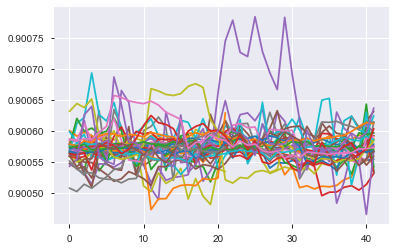

In [340]:
import matplotlib.pyplot as plt
test_cluster_1
for c in clusters_data_list[3]['SecurityID']:
    plt.plot(new_data[new_data['SecurityID']==c].G_scale.values)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
test_cluster_1
for c in clusters_data_list[1]['SecurityID']:
    plt.plot(new_data[new_data['SecurityID']==c].G_scale.values)
plt.show()

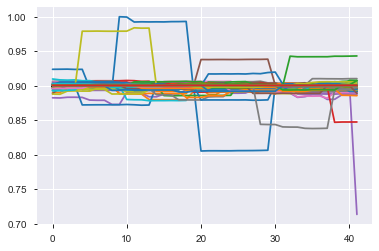

11934


In [335]:
import matplotlib.pyplot as plt
test_cluster_1
for c in clusters_data_list[5]['SecurityID']:
    plt.plot(new_data[new_data['SecurityID']==c].G_scale.values)
plt.show()
print(len(clusters_data_list[5]))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [334]:
from pandas_profiling import ProfileReport
prof = ProfileReport(clusters_data_list[0])
prof

In [ ]:
prof1 = ProfileReport(clusters_data_list[1])
prof1

In [341]:
prof2 = ProfileReport(clusters_data_list[3])
prof2

In [ ]:
#Feature extraction